In [71]:
import sys
import os

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

from src.features import build_features

sns.set_style()
plt.rcParams["figure.figsize"] = (12, 6)

In [73]:
DIAGS_MAS_RELEVANTES = [
    "C33X",
    "C340",
    "C341",
    "C342",
    "C343",
    "C381",
    "C384",
    "C450",
    "C780",
    "C782",
    "D143",
    "D381",
    "E848",
    "I080",
    "I081",
    "I340",
    "I350",
    "I351",
    "I352",
    "I420",
    "I456",
    "I472",
    "I495",
    "I710",
    "I712",
    "J398",
    "J47X",
    "J679",
    "J841",
    "J848",
    "J849",
    "J860",
    "J869",
    "J90X",
    "J91X",
    "J931",
    "J955",
    "J980",
    "M348",
    "Q211",
    "Q231",
    "Q676",
    "T820",
    "T821",
    "Z450",
]

In [74]:
# Lee la base de datos
egresos_torax = pd.read_csv("../data/processed/egresos_torax_mes_y_dia.csv")

# Crea columna de fecha en datetime
egresos_torax["FECHA_EGRESO"] = pd.to_datetime(
    egresos_torax["ANO_EGRESO"].astype(str)
    + "-"
    + egresos_torax["MES_EGRESO"].astype(str)
    + "-"
    + egresos_torax["DIA_EGRESO"].astype(str),
    format="%Y-%m-%d",
)

# Elimina columnas redundantes
egresos_torax = egresos_torax.drop(
    columns=[
        "ANO_EGRESO",
        "MES_EGRESO",
        "DIA_EGRESO",
        "ESTABLECIMIENTO_SALUD",
        "GLOSA_ESTABLECIMIENTO_SALUD",
    ]
).sort_values("FECHA_EGRESO")

# Elimina el anio 2020, debido a que es anomalo (Pandemia COVID)
egresos_torax = egresos_torax.query("FECHA_EGRESO < '2020-01-01'")

# Elige la fecha como indice de los datos
egresos_torax = egresos_torax.set_index("FECHA_EGRESO")

# Filtra los egresos de los diags mas relevantes
egresos_torax_mas_relevantes = egresos_torax.query("DIAG1.isin(@DIAGS_MAS_RELEVANTES)")

# Forecasting Multivariado

En este apartado se quiere realizar un modelo predicitvo que tome en cuenta cada uno de los diagnósticos distintos que existen en el INT. Para esto, se realizará un modelo de previsión multivariado, donde cada uno de las variables será uno de los diagnósticos.

In [75]:
# Transforma los egresos a formato long con cada fecha rellenada
df_multivariado = (
    (
        pd.pivot_table(
            egresos_torax.reset_index(),
            index="FECHA_EGRESO",
            values="n_egresos",
            columns="DIAG1",
            fill_value=0,
            aggfunc="sum",
        )
        .resample("M")
        .sum()
    )
    .reset_index()
    .melt(id_vars="FECHA_EGRESO", value_name="n_egresos")
    .sort_values(["FECHA_EGRESO", "DIAG1"])
)

# Transforma los egresos a formato long con cada fecha rellenada
df_relevantes_multivariado = (
    (
        pd.pivot_table(
            egresos_torax_mas_relevantes.reset_index(),
            index="FECHA_EGRESO",
            values="n_egresos",
            columns="DIAG1",
            fill_value=0,
            aggfunc="sum",
        )
        .resample("M")
        .sum()
    )
    .reset_index()
    .melt(id_vars="FECHA_EGRESO", value_name="n_egresos")
    .sort_values(["FECHA_EGRESO", "DIAG1"])
)

display(df_relevantes_multivariado)

,FECHA_EGRESO,DIAG1,n_egresos
0,2001-01-31,C33X,0
228,2001-01-31,C340,0
456,2001-01-31,C341,0
684,2001-01-31,C342,0
912,2001-01-31,C343,0
...,...,...,...
9347,2019-12-31,Q231,0
9575,2019-12-31,Q676,0
9803,2019-12-31,T820,5
10031,2019-12-31,T821,4


## Separar en train y test

In [76]:
CORTE_TEST = "2019-01-01"

# Separa en train y test para cada diagnostico distinto
train_multivariable = df_multivariado[df_multivariado["FECHA_EGRESO"] < CORTE_TEST].copy()
test_multivariable = df_multivariado[df_multivariado["FECHA_EGRESO"] >= CORTE_TEST].copy()

Como ejercicio, haremos la prediccion del proximo mes

## Crear valor y

In [77]:

# Obtiene el valor del siguiente mes para cada uno de los productos
train_multivariable["n_egresos_proximo_mes"] = train_multivariable.groupby("DIAG1")[
    "n_egresos"
].shift(-1)
# Elimina los ultimos meses de los datos
train_multivariable = train_multivariable.dropna()

# Obtiene el valor del siguiente mes para cada uno de los productos
test_multivariable["n_egresos_proximo_mes"] = test_multivariable.groupby("DIAG1")[
    "n_egresos"
].shift(-1)
test_multivariable = test_multivariable.dropna()

display(train_multivariable.tail(20))

,FECHA_EGRESO,DIAG1,n_egresos,n_egresos_proximo_mes
275638,2018-11-30,Z768,0,0.0
275866,2018-11-30,Z769,0,0.0
276094,2018-11-30,Z821,0,0.0
276322,2018-11-30,Z851,0,0.0
276550,2018-11-30,Z858,0,0.0
276778,2018-11-30,Z877,0,0.0
277006,2018-11-30,Z911,0,0.0
277234,2018-11-30,Z924,0,0.0
277462,2018-11-30,Z930,0,0.0
277690,2018-11-30,Z941,0,0.0


Los datos quedan hasta el penultimo mes! Esta hecho correctamente

## Crear variables X

In [78]:
# Crea variable lag en train y test
train_multivariable["lag_1"] = train_multivariable.groupby("DIAG1")["n_egresos"].shift(1)
test_multivariable["lag_1"] = test_multivariable.groupby("DIAG1")["n_egresos"].shift(1)

In [79]:
display(train_multivariable.query("DIAG1 == 'C341'"))

,FECHA_EGRESO,DIAG1,n_egresos,n_egresos_proximo_mes,lag_1
28500,2001-01-31,C341,0,0.0,NaN
28501,2001-02-28,C341,0,1.0,0.0
28502,2001-03-31,C341,1,3.0,0.0
28503,2001-04-30,C341,3,1.0,1.0
28504,2001-05-31,C341,1,0.0,3.0
...,...,...,...,...,...
28710,2018-07-31,C341,19,31.0,27.0
28711,2018-08-31,C341,31,17.0,19.0
28712,2018-09-30,C341,17,15.0,31.0
28713,2018-10-31,C341,15,14.0,17.0


In [80]:
# Crea variable diff en train y test
train_multivariable["diff_1"] = train_multivariable.groupby("DIAG1")["n_egresos"].diff(1)
test_multivariable["diff_1"] = test_multivariable.groupby("DIAG1")["n_egresos"].diff(1)

display(train_multivariable.query("DIAG1 == 'C341'"))

,FECHA_EGRESO,DIAG1,n_egresos,n_egresos_proximo_mes,lag_1,diff_1
28500,2001-01-31,C341,0,0.0,NaN,NaN
28501,2001-02-28,C341,0,1.0,0.0,0.0
28502,2001-03-31,C341,1,3.0,0.0,1.0
28503,2001-04-30,C341,3,1.0,1.0,2.0
28504,2001-05-31,C341,1,0.0,3.0,-2.0
...,...,...,...,...,...,...
28710,2018-07-31,C341,19,31.0,27.0,-8.0
28711,2018-08-31,C341,31,17.0,19.0,12.0
28712,2018-09-30,C341,17,15.0,31.0,-14.0
28713,2018-10-31,C341,15,14.0,17.0,-2.0


In [81]:
# Crea rolling variables en train y test
train_multivariable["mean_4"] = (
    train_multivariable.groupby("DIAG1")["n_egresos"]
    .rolling(4)
    .mean()
    .reset_index(level=0, drop=True)
)

test_multivariable["mean_4"] = (
    test_multivariable.groupby("DIAG1")["n_egresos"]
    .rolling(4)
    .mean()
    .reset_index(level=0, drop=True)
)

display(train_multivariable.query("DIAG1 == 'C341'"))

,FECHA_EGRESO,DIAG1,n_egresos,n_egresos_proximo_mes,lag_1,diff_1,mean_4
28500,2001-01-31,C341,0,0.0,NaN,NaN,NaN
28501,2001-02-28,C341,0,1.0,0.0,0.0,NaN
28502,2001-03-31,C341,1,3.0,0.0,1.0,NaN
28503,2001-04-30,C341,3,1.0,1.0,2.0,1.00
28504,2001-05-31,C341,1,0.0,3.0,-2.0,1.25
...,...,...,...,...,...,...,...
28710,2018-07-31,C341,19,31.0,27.0,-8.0,18.50
28711,2018-08-31,C341,31,17.0,19.0,12.0,23.75
28712,2018-09-30,C341,17,15.0,31.0,-14.0,23.50
28713,2018-10-31,C341,15,14.0,17.0,-2.0,20.50


In [82]:
# Pone la fecha como indice
train_multivariable = train_multivariable.set_index("FECHA_EGRESO")
test_multivariable = test_multivariable.set_index("FECHA_EGRESO")

In [83]:
# Agrega variables relacionadas a la fecha
train_multivariable = build_features.add_time_series_columns(train_multivariable)
test_multivariable = build_features.add_time_series_columns(test_multivariable)

## Entrenar modelos

In [84]:
train_multivariable.head(5)

,DIAG1,n_egresos,n_egresos_proximo_mes,lag_1,diff_1,mean_4,quarter,month,year,season,is_leap_year,is_quarter_start,is_quarter_end,days_in_month,holidays_per_month,weekends_per_month,business_days_per_month
FECHA_EGRESO,,,,,,,,,,,,,,,,,
2001-01-31,A020,0,0.0,NaN,NaN,NaN,1,1,2001,1,0,0,0,31,1,8,23
2001-01-31,A047,0,0.0,NaN,NaN,NaN,1,1,2001,1,0,0,0,31,1,8,23
2001-01-31,A060,0,0.0,NaN,NaN,NaN,1,1,2001,1,0,0,0,31,1,8,23
2001-01-31,A083,0,0.0,NaN,NaN,NaN,1,1,2001,1,0,0,0,31,1,8,23
2001-01-31,A084,0,0.0,NaN,NaN,NaN,1,1,2001,1,0,0,0,31,1,8,23


In [85]:
features = [
    "n_egresos",
    "lag_1",
    "diff_1",
    "mean_4",
    "quarter",
    "month",
    "year",
    "season",
    "is_leap_year",
    "is_quarter_start",
    "is_quarter_end",
    "days_in_month",
    "holidays_per_month",
    "weekends_per_month",
    "business_days_per_month",
]

In [86]:
from sklearn.impute import SimpleImputer

In [87]:
# Impute valores NaN en train y test
imputer = SimpleImputer()
X_train_multivariable = imputer.fit_transform(train_multivariable[features])
y_train_multivariable = train_multivariable["n_egresos_proximo_mes"]

X_test_multivariable = imputer.transform(test_multivariable[features])
y_test_multivariable = test_multivariable["n_egresos_proximo_mes"]

c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\sklearn\utils\valid

In [88]:
# Entrena modelo
xgb_multivariable = XGBRegressor(
    colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8
)
xgb_multivariable.fit(X_train_multivariable, y_train_multivariable)

c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [89]:
# Evalua metricas de rendimiento en train y test
yhat_train_xgb_multivariable = xgb_multivariable.predict(X_train_multivariable)
yhat_test_xgb_multivariable = xgb_multivariable.predict(X_test_multivariable)

In [90]:
def wmape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

In [91]:
# Baseline
y_pred = train_multivariable["n_egresos"]
y_true = train_multivariable["n_egresos_proximo_mes"]

print(mean_absolute_error(y_true, y_pred))
print(wmape(y_true, y_pred))

0.19941292326338914
0.5978764478764479


c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is depreca

In [92]:
print(mean_absolute_error(y_train_multivariable, yhat_train_xgb_multivariable))
print(wmape(y_train_multivariable, yhat_train_xgb_multivariable))

print(mean_absolute_error(y_test_multivariable, yhat_test_xgb_multivariable))
print(wmape(y_test_multivariable, yhat_test_xgb_multivariable))

0.19149731174488804
0.5741439955358317
0.24263264689355127
0.6590552572366962


c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is depreca

In [93]:
prueba = test_multivariable[["DIAG1", "n_egresos_proximo_mes"]].copy()
prueba["yhat"] = yhat_test_xgb_multivariable
prueba["errores"] = np.abs(prueba["yhat"] - prueba["n_egresos_proximo_mes"])

<Axes: xlabel='FECHA_EGRESO'>

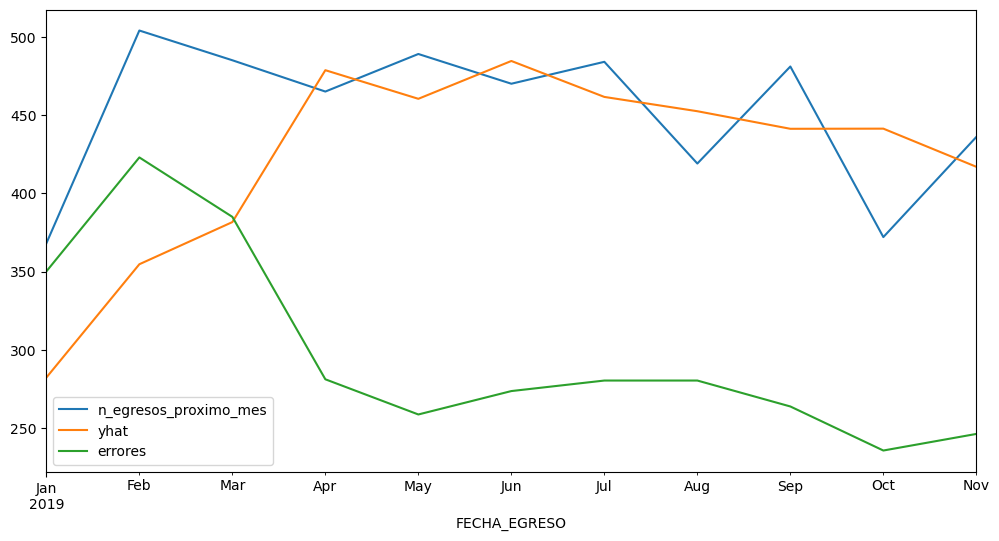

In [94]:
prueba.resample("M").sum().plot()